# Time Series Analysis on "Data Science" Keyword

This notebook is for my "Time Series Analysis - Google Trends" project uploaded on my website [here](https://ardinradestian.wordpress.com/2021/06/10/time-series-analysis-google-trends). Please visit my website first to understand my code more clearly but I hope my descriptions and comments below would help to understand the code.

The dataset I will be using was downloaded from google trends with "Data Science" Keyword from Jan 2012 to May 2021. CSV file can be downloaded [here](https://github.com/ardinr/time-series-data-science).

Major steps that I will do:
- Forecasting
    - Import and load dataset
    - Preparing dataset
    - Induce stationarity by transforming dataset
    - Fit model with rolling forecast origin method
    - Models Evaluation
- Decomposition

## Time Series Analysis

Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

Create Function

In [2]:
#adf_test function for later use in inducing stationarity
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0].round(5)}')
    print(f'p-value: {result[1].round(5)}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'{key} : {value.round(5)}')

#Root Mean Square Error to evaluate forecasting model
def RMSE(actual, predict):
    return round(np.sqrt(((actual-predict)**2).mean()),5)

### Load Dataset

In [3]:
#load dataset from csv files
import_data_science = pd.read_csv('./Project_dataset/trend_data_science.csv', skiprows=1)

In [4]:
import_data_science.head()

,Bulan,data science: (Seluruh dunia)
0,2012-01,7
1,2012-02,7
2,2012-03,7
3,2012-04,6
4,2012-05,6


**What 0-100 value represent according to google trends:**
>"Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means that there was not enough data for this term."

In [5]:
#copy imported dataset to preserve original dataset
data_science = import_data_science.copy(deep=True)

#rename columns
data_science.rename(columns={'Bulan':'bulan','data science: (Seluruh dunia)':'popularity'},inplace=True)

### Preparing Dataset

In [6]:
data_science.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   bulan       113 non-null    object
 1   popularity  113 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ KB


In [7]:
data_science.describe()

,popularity
count,113.000000
mean,40.256637
std,29.471166
min,6.000000
25%,12.000000
50%,32.000000
75%,72.000000
max,100.000000


In [8]:
#change 'bulan' column data type to datetime
data_science.bulan = pd.to_datetime(data_science.bulan)

#set 'bulan' column to index
data_science.set_index('bulan',inplace=True)

#infer frequency for later use when modeling
data_science = data_science.popularity.asfreq(pd.infer_freq(data_science.index))

#take data from January 2015 to the latest
start_date = pd.to_datetime('2015/1/1')
data_science = data_science[data_science.index >= start_date]

Text(0.5, 0, '')

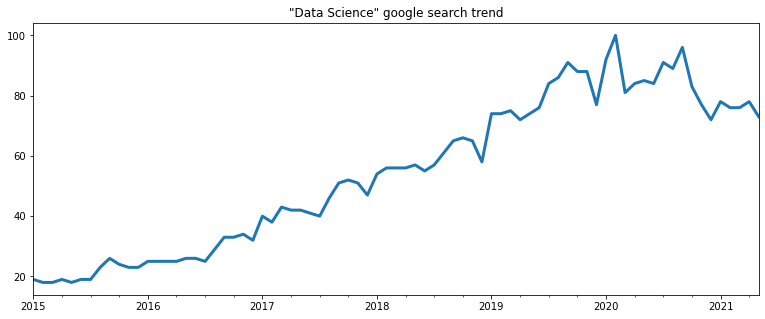

In [9]:
#plot data
data_science.plot(figsize=(13,5),linewidth=3)
plt.title('"Data Science" google search trend')
plt.xlabel("")

### Split Train and Test Dataset

Split dataset into train and test datasets. During training process I will try to avoid data leakage, although in validation process I'm going to use rolling forecast origin which will be using test dataset in it's process, but I think it's justifiable for the reason I will elaborate later.

In [10]:
from datetime import timedelta

#Take 2 years from latest data as a test set
train_end = data_science.index.max() + pd.DateOffset(years=-2)

ds_train = data_science[:train_end]
ds_test = data_science[train_end + timedelta(days=1):]

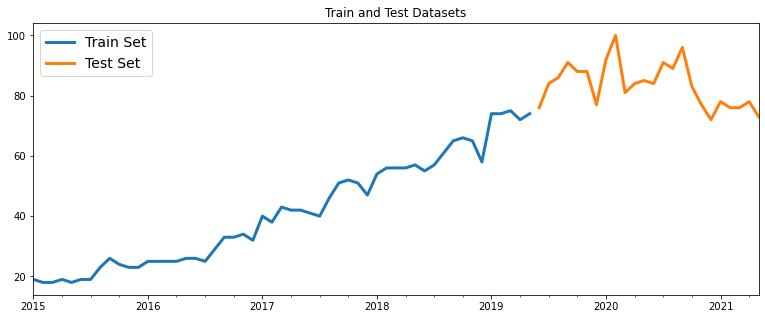

In [11]:
#plot train and test dataset
plt.figure(figsize=(13,5))
ds_train.plot(label='Train Set',linewidth=3)
ds_test.plot(label='Test Set',linewidth=3)
plt.title('Train and Test Datasets')
plt.xlabel("")
plt.legend(prop={'size': 14})

### Induce Stationarity

Most time series analysis procedure is assuming stationarity of the data. So, non-stationary data are often transformed to become stationary. I'm going to transform the data into stationarity before fitting them.

Properties of stationary data (weak stationarity):  
**$\mu$** is Constant, **$\sigma$** is Constant, There is no **Seasonality**  




Article: [stationarity](https://otexts.com/fpp2/stationarity.html)

### Transformation and Inverse Formula  
These transformation are needed to induce stationarity and I also created inverse formula so I could recover transformed data back to original state. I calculated the formula for each transformation and their inverses, then I created python functions of them.

Transformation:   
>1. Remove trend:  
>$d_{t} = v_{t} - v_{t-1}$  
>
>2. Remove changing volatility:  
>$c_{t} = d_{t} \div \sigma $   
>
>3. Remove seasonality:  
>$s_{t} = c_{t} - c_{t-12}$  
>
>4. Full Transformation:  
>$\hat{s}_{t} =  \frac{v_{t} - v_{t-1}}{\sigma} - \frac{v_{t-12} - v_{t-13}}{\sigma} $  

In [12]:
#Functions on single transformation and full transformation

#function to find relevant standard deviation for each month
def row_stdev(series): 
    annual_volatility = series.groupby(series.index.year).std() #standard deviation for each year
    map_row = series.index.map(lambda x: annual_volatility[x.year]) #map each row with standard deviation on relevant year
    row_stdev = pd.Series(map_row,index=series.index) 
    return row_stdev

#difference function
def diff(series):
    diff = pd.Series((series[1:].values - series[:-1].values),index = series[1:].index)
    return diff

#remove volatility function
def remove_volatility(series):
    remove_volatility = pd.Series(series.values / row_stdev(series).values,index=series.index) # divide each row by relevant year standard deviation
    return remove_volatility

#remove seasonality function
def remove_seasonality(series):
    remove_seasonality = pd.Series((series[12:].values-series[:-12].values),index=series[12:].index) #Subtract Ct+12 with Ct
    return remove_seasonality

#full transformation mention above 
def full_transform(series):
    diff = series.diff().dropna()
    stdev = row_stdev(diff).fillna(method='ffill')
    full_transform = pd.Series((((series[13:].values-series[12:-1].values)/stdev[12:].values) -
                            (series[1:-12].values-series[:-13].values)/stdev[:-12].values), index=series[13:].index)
    return full_transform

Inverse:  
>1. Inverse 1:  
>$𝑑_{t}^{−1} = 𝑣_{𝑡}+𝑣_{𝑡−1} $  
>
>2. Inverse 2:  
>$𝑐_{t}^{−1} = 𝑑_{𝑡}. 𝜎  $  
>
>3. Inverse 3:  
>$𝑠_{t}^{−1} = 𝑐_{𝑡}+𝑐_{𝑡−12}$  
>
>4. Full Inverse:  
>$\hat{v}_{t} = (\hat{s}_{t} + \frac{v_{t-12}-v_{t-13}}{\sigma}).\sigma + v_{t-1}$

In [13]:
#Functions on single inverse and full inverse

#function to find relevant standard deviation for each month
def row_stdev(series): 
    annual_volatility = series.groupby(series.index.year).std() #standard deviation for each year
    map_row = series.index.map(lambda x: annual_volatility[x.year]) #map each row with standard deviation on relevant year
    return pd.Series(map_row,index=series.index) 

#inverse of difference 
def diff_inverse(orig_series, series):
    t_lost = orig_series.count() - series.count()
    diff_inverse = pd.Series((series.values + orig_series[:-t_lost].values),index=series.index)
    return diff_inverse

#inverse of remove volatility 
def vol_inverse(orig_series, series):
    t_lost = orig_series.count() - series.count()
    diff = orig_series.diff().dropna()
    stdev = row_stdev(diff)
    vol_inverse = pd.Series(series.values*stdev[t_lost-1:].values,index=series.index)
    return vol_inverse

#inverse of remove seasonality 
def sea_inverse(orig_series, series):
    t_lost = orig_series.count() - series.count()
    diff = orig_series.diff().dropna()
    stdev = row_stdev(diff)
    sea_inverse = pd.Series(series.values + (orig_series[1:1-t_lost].values-orig_series[:-t_lost].values)/
                            stdev[:1-t_lost].values,index=series.index)
    return sea_inverse

#full inverse of functions above 
def full_inverse(orig_series, series):
    t_lost = orig_series.count() - series.count()
    diff = orig_series.diff().dropna()
    stdev = row_stdev(diff)
    full_inverse = pd.Series(((series.values + (orig_series[1:1-t_lost].values-orig_series[:-t_lost].values)
                    /stdev[:1-t_lost].values) *stdev[t_lost-1:].values + orig_series[t_lost-1:-1].values), index=series.index)
    return full_inverse

### Transforming Dataset

#### Original data

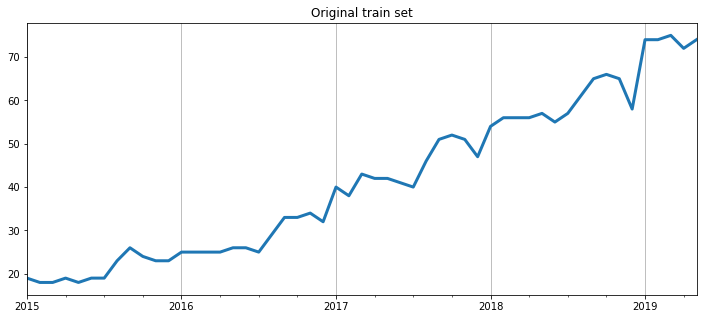

In [14]:
ds_train.plot(figsize=(12,5),linewidth=3)
plt.title('Original train set')
plt.xlabel("")
plt.grid(axis='x')

We can detect trend in this dataset very clearly with visual observation. But, to give more objective view, I’m going to do Augmented Dickey–Fuller(ADF) test.

Augmented Dickey–Fuller test

In [15]:
#Augmented Dickey–Fuller test
print('Augmented Dickey–Fuller test\n')
adf_test(ds_train)

Augmented Dickey–Fuller test

ADF Statistic: 2.54703
p-value: 0.99906
Critical Values:
1% : -3.60098
5% : -2.93513
10% : -2.60596


The null hypothesis of the ADF test is that a unit root is present in the sample, the alternative hypothesis is trend-stationarity. ADF test fail to reject null hypothesis with p-value of almost 1, it's almost certain unit root is present in the data, so we can infer that the data is not-stationary.

#### Removing trend by taking first difference

first difference: $d_{t} = v_{t} - v_{t-1}$  
first difference inverse: $d_{t}^{-1} = v_{t} + v_{t-1}$

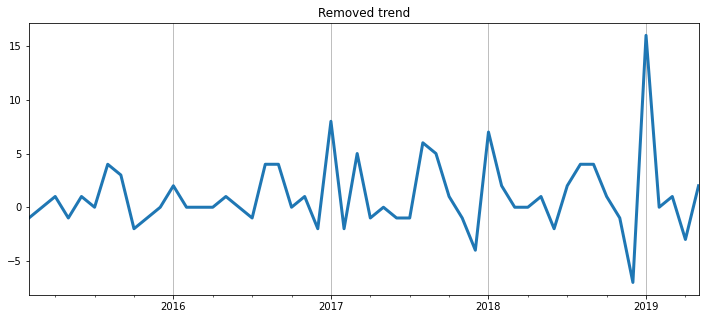

In [16]:
ds_diff = diff(ds_train)

#plot differenced data
ds_diff.plot(figsize=(12,5),linewidth=3)
plt.title('Removed trend')
plt.xlabel("")
plt.grid(axis='x')

#### Removing changing volatility

remove changing volatility: $c_{t} = d_{t} \div \sigma $  
remove changing volatility inverse: $c_{t}^{-1} = d_{t} * \sigma $

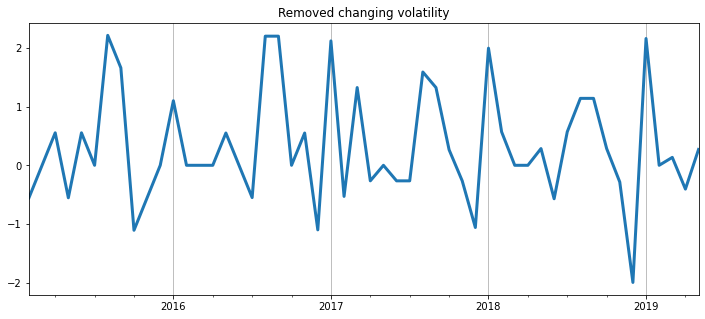

In [17]:
ds_rvol = remove_volatility(ds_diff) # divide each row by relevant year standard deviation

#plot removed volatility data
ds_rvol.plot(figsize=(12,5),linewidth=3)
plt.title('Removed changing volatility')
plt.xlabel("")
plt.grid(axis='x')

Now the data seems too have same volatility over the years. Lastly, we need to check seasonality before we can assume "stationarity".

In [18]:
#Check seasonality by taking means for each month
ds_rvol.groupby([ds_rvol.index.month,ds_rvol.index.month_name()]).mean()

bulan  bulan    
1      January      1.846619
2      February    -0.102779
3      March        0.292372
4      April       -0.023329
5      May          0.110501
6      June        -0.070523
7      July        -0.061279
8      August       1.788707
9      September    1.583796
10     October     -0.139439
11     November    -0.138580
12     December    -1.040452
dtype: float64

#### Removing Seasonality

remove seasonality: $s_{t} = c_{t} - c_{t-12}$  
remove seasonality inverse: $s_{t}^{-1} = c_{t} + c_{t-12}$ 

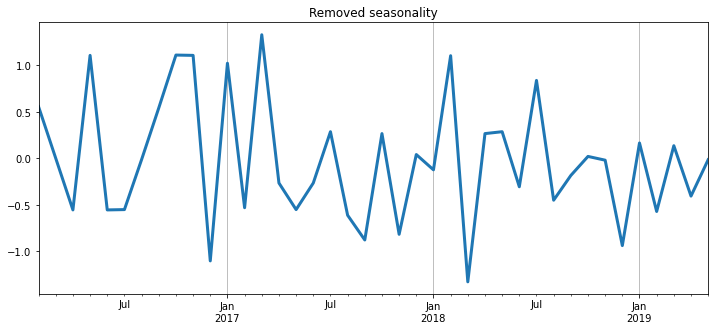

In [19]:
ds_rsea = remove_seasonality(ds_rvol)

#plot removed seasonality
ds_rsea.plot(figsize=(12,5),linewidth=3)
plt.title('Removed seasonality')
plt.xlabel("")
plt.grid(axis='x')

### ADF Test

In [20]:
print('Augmented Dickey–Fuller test\n')
adf_test(ds_rsea)

Augmented Dickey–Fuller test

ADF Statistic: -8.71253
p-value: 0.0
Critical Values:
1% : -3.6104
5% : -2.93911
10% : -2.60806


With this result, we can reject null hypothesis with alpha 0.01. The alternative hypothesis is trend-stationarity, therefore we can assume stationarity for this data. Now, we can use this data to fit into our model.

### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) Plot

Autocorrelation (auto=self) function is a function that use correlation with it's own past data (lags). ACF do correlation with past data at the same time and PACF do it individually. Usually we can determine the best AR (using PACF) and MA (using ACF) lags from these plot.

Article: [ACF & PACF](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation)  
Video: [ACF & PACF](https://www.youtube.com/watch?v=DeORzP0go5I)

#### ACF Plot

<function matplotlib.pyplot.show(*args, **kw)>

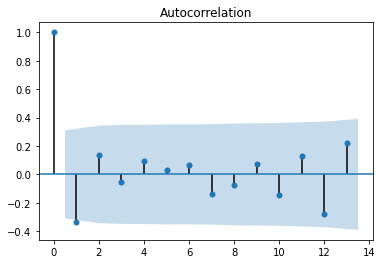

In [21]:
plot_acf(ds_rsea,lags=13)
plt.show

This ACF plot shows that lag 1 has significant correlation and shutoff after that, therefore I’m going to try lag 1 in my MA model

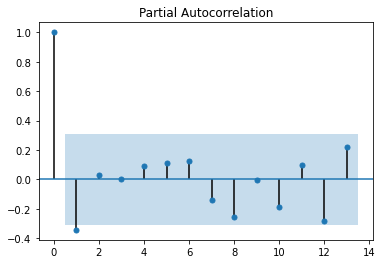

In [22]:
plot_pacf(ds_rsea,lags=13)
plt.show()

This PACF plot shows lag 1 has a significant correlation, I’m going to try lag 1 in my AR model. There is still pretty strong correlation on lag 12 even after removing seasonality, later I will try to unremoved seasonality and use SARIMA model instead and compare the result.

### Try to Fit the ARMA Model

#### Fitting ARMA model

To model using ARMA, I use ARIMA function from statsmodel, but I'm not using the d(difference) in ARIMA's (p,d,q)

Article: [time series forecasting](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

In [23]:
order = (1,0,1)
model = ARIMA(ds_rsea,order)
model_fit = model.fit()

In [24]:
start = ds_test.index[0]
end = ds_test.index[-1]
model_predict = model_fit.predict(start= start,end= end )

#### Inverse function for prediction

I created a function to inverse the prediction after using ARIMA

In [25]:
#inverse for n period prediction
def inverse_prediction(orig_series, prediction):
    expand_series = orig_series.copy(deep=True)
    #first prediction
    diff = expand_series.diff().dropna()
    year_std = diff.groupby(diff.index.year).std()
    first_pred = (prediction[0] + ((expand_series[-12]-expand_series[-13]) /
                (year_std[expand_series.index[-12].year]))) * year_std[prediction.index.year[0]]+expand_series[-1]
    expand_series[prediction.index[0]] = first_pred
    
    #next prediction
    for i in range(1,len(prediction)):
        diff = expand_series.diff().dropna()
        year_std = diff.groupby(diff.index.year).std().fillna(year_std.values[-1])
        #on a new year which doesn't have a standard deviation yet, use previous year standard deviation
        pred_std = (year_std.values[-1] if year_std.get(prediction.index.year[i])==None else year_std.get(prediction.index.year[i]))
        next_pred = (prediction[i] + ((expand_series[-12]-expand_series[-13]) / 
                    (year_std[expand_series.index[-12].year]))) * pred_std + expand_series[-1]
        expand_series[prediction.index[i]] = next_pred
    return expand_series.loc[prediction.index[0]:]

Inversing the prediction into original state

In [26]:
#Inversing the prediction
ds_predict = inverse_prediction(ds_train,model_predict)

Root Mean Square Error on test data and prediction data

In [27]:
#Root Mean Square Error
print(f'RMSE: {RMSE(ds_test,ds_predict)} ')

RMSE: 18.08436 


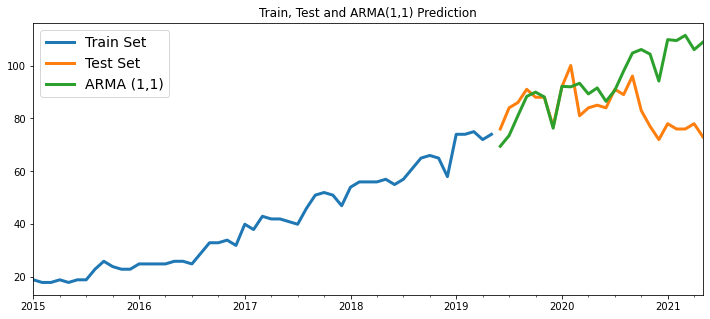

In [28]:
#plot train,test and predict data
plt.figure(figsize=(12,5))
ds_train.plot(label="Train Set",linewidth=3)
ds_test.plot(label="Test Set",linewidth=3)
ds_predict.plot(label="ARMA (1,1)",linewidth=3)
plt.title('Train, Test and ARMA(1,1) Prediction')
plt.xlabel("")
plt.legend(prop={'size': 14})

This model shows promising start but began to deviate away as the actual dataset peaked in 2020 and keep following trend from train data. This kind of problem is the reason it is so hard to predict too many period into the future. Even though the dataset seems predictable until year 2020, we never know what might happen in the future.

In most case of the real world business problem, usually we only have to predict 1 to 3 period into the future and are able to update our dataset with new data before continuing to predict into the future. We can simulate this condition with Rolling Forecast Origin to better evaluate performances of our models. I'm going to use this evaluation method together with Root Mean Square Error(RMSE) to select the best model for our prediction.

### ARMA with Rolling Forecast Origin
Using Rolling Forecast Origin method, I'm going to predict 1 month into the future for each new data. I will be using ARMA with different combination of order.  
Each new data will receive these treatments: 
- Remove trend
- Remove changing volatility
- Remove seasonality
- Fit with ARMA
- Inverse prediction to original state

In [29]:
#create a function with train set, test set and ARIMA order tuple (p,d,q) as input
#and return a prediction with rolling forecast origin method
def rolling_forecast_origin(train_set,test_set,order):
    #create a copy of train data and be used to insert new data on each loop
    rolling_data = train_set.copy(deep=True)
    rolling_data = rolling_data.asfreq(pd.infer_freq(rolling_data.index))

    #list for final prediction
    ds_predict = []

    for i in range(0,len(test_set)):
        #transform data to stationarity with full_transform function
        transform_data = full_transform(rolling_data)

        #fit the model
        model = ARIMA(transform_data,order)
        model_fit = model.fit()
        prediction = model_fit.predict(test_set.index[i])

        #standard deviation for each year
        diff = rolling_data.diff().dropna()
        year_std = diff.groupby(diff.index.year).std().fillna(method='ffill')

        #use previous year standard deviation for first month of unknown year standard deviation
        if year_std.get(prediction.index.year[0]) == None:
            pred_std = year_std.values[-1]    
        else:
            pred_std = year_std.get(prediction.index.year[0])

        #inverse back to original scale and append the output to ds_predict list
        inverse_pred = (prediction.values + (rolling_data[-12]-rolling_data[-13]) / 
                        year_std[rolling_data.index[-12].year]) * pred_std + rolling_data[-1]
        ds_predict.append(round(inverse_pred[0],5))

        #update new data to rolling_data
        if i < len(test_set):
            rolling_data[test_set.index[i]] = test_set[i]

    ds_predict = pd.Series(ds_predict,index=test_set.index)
    return ds_predict

In [30]:
#create a series for model performance evaluation
model_performance = pd.Series(name='RMSE',dtype='float64')

#create a dataframe to take each model prediction
model_forecast = pd.DataFrame()

#### Fit ARMA(1,1)

In [31]:
#Fit ARMA(1,1)
ds_predict = rolling_forecast_origin(ds_train,ds_test,(1,0,1))

#save model prediction and performance
model_forecast['ARMA(1,1)'] = ds_predict
model_performance['ARMA(1,1)'] = RMSE(ds_test,ds_predict)

In [32]:
#Root Mean Square Error
print(f'ARMA(1,1)\nRMSE: {RMSE(ds_test,ds_predict)} ')

ARMA(1,1)
RMSE: 7.23176 


#### Fit ARMA(1,0)

In [33]:
#Fit ARMA(1,0)
ds_predict = rolling_forecast_origin(ds_train,ds_test,(1,0,0))

#save model prediction and performance
model_forecast['AR(1)'] = ds_predict
model_performance['AR(1)'] = RMSE(ds_test,ds_predict)

In [34]:
#Root Mean Square Error
print(f'AR(1)\nRMSE: {RMSE(ds_test,ds_predict)} ')

AR(1)
RMSE: 7.18628 


### SARIMA with Rolling Forecast Origin

On ACF and PACF plot displayed before, we can see that there is still significat correlation at lag 12 even though I had tried to remove them. So I will not remove seasonality and use SARIMA instead.  
Each new data will receive these treatments: 
- Remove trend
- Remove changing volatility
- Fit with SARIMA
- Inverse prediction to original state

In [35]:
#create a function with train set, test set , SARIMAX order and seasonal order tuples (p,d,q) (P,D,Q,s) as input
#and return a prediction with rolling forecast origin method
def rolling_forecast_origin_sarima(train_set,test_set,order,seasonal_order):
    #create a copy of train data and be used to insert new data on each loop
    rolling_data = train_set.copy(deep=True)
    rolling_data = rolling_data.asfreq(pd.infer_freq(rolling_data.index))

    #list for final prediction
    ds_predict = []

    for i in range(0,len(test_set)):
        #transform data to stationarity with full_transform function
        transform_data = sea_inverse(rolling_data,full_transform(rolling_data))

        #fit the model
        model = SARIMAX(transform_data,order=order,seasonal_order=seasonal_order)
        model_fit = model.fit()
        prediction = model_fit.predict(test_set.index[i])

        #standard deviation for each year
        diff = rolling_data.diff().dropna()
        year_std = diff.groupby(diff.index.year).std().fillna(method='ffill')

        #use previous year standard deviation for first month of unknown year standard deviation
        if year_std.get(prediction.index.year[0]) == None:
            pred_std = year_std.values[-1]    
        else:
            pred_std = year_std.get(prediction.index.year[0])

        #inverse back to original scale and append the output to ds_predict list
        inverse_pred = prediction.values * pred_std + rolling_data[-1]
        ds_predict.append(round(inverse_pred[0],5))

        #update new data to rolling_data
        if i < len(test_set):
            rolling_data[test_set.index[i]] = test_set[i]

    ds_predict = pd.Series(ds_predict,index=test_set.index)
    return ds_predict

#### Fit SARIMA(1,0,1)(1,0,0,12)

In [36]:
#Fit SARIMA(1,0,1)(1,0,0,12)
ds_predict = rolling_forecast_origin_sarima(ds_train,ds_test,(1,0,1),(1,0,0,12))

#save model prediction and performance
model_forecast['Seasonal ARMA(1,1)'] = ds_predict
model_performance['Seasonal ARMA(1,1)'] = RMSE(ds_test,ds_predict)

C:\Users\JimiOmar\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\JimiOmar\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [37]:
#Root Mean Square Error
print(f'Seasonal ARMA(1,1)\nRMSE: {RMSE(ds_test,ds_predict)} ')

Seasonal ARMA(1,1)
RMSE: 6.6638 


#### Fit SARIMA(1,0,0)(1,0,0,12)

In [38]:
#Fit SARIMA(1,0,0)(1,0,0,12)
ds_predict = rolling_forecast_origin_sarima(ds_train,ds_test,(1,0,0),(1,0,0,12))

#save model prediction and performance
model_forecast['Seasonal AR(1)'] = ds_predict
model_performance['Seasonal AR(1)'] = RMSE(ds_test,ds_predict)

In [39]:
#Root Mean Square Error
print(f'Seasonal AR(1)\nRMSE: {RMSE(ds_test,ds_predict)} ')

Seasonal AR(1)
RMSE: 6.58638 


### Models Evaluation

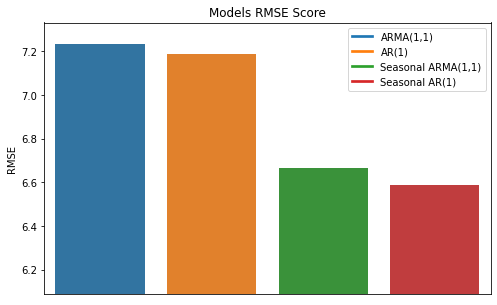

In [40]:
#Plot performance
plt.figure(figsize=(8,5))
sns.barplot(model_performance.index,model_performance,palette=['tab:blue','tab:orange','tab:green','tab:red'])
plt.ylim(model_performance.min()-0.5,model_performance.max()+0.1)
plt.legend(model_performance.index)
plt.title('Models RMSE Score')
plt.xticks(ticks=[])

ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('tab:blue')
leg.legendHandles[1].set_color('tab:orange')
leg.legendHandles[2].set_color('tab:green')
leg.legendHandles[3].set_color('tab:red')

In [41]:
#perfomance result (RMSE)
model_performance.to_frame()

,RMSE
"ARMA(1,1)",7.23176
AR(1),7.18628
"Seasonal ARMA(1,1)",6.66380
Seasonal AR(1),6.58638


### Conclusion

#### **SARIMA(1,0,0)(1,0,0,12) or Seasonal AR(1)** has the best RMSE score with 6.59 (lowest) on Rolling Forecast Origin method, This will be the model I choose for future prediction. This model is very simple, which usually will perform better in long-term than a complex one.

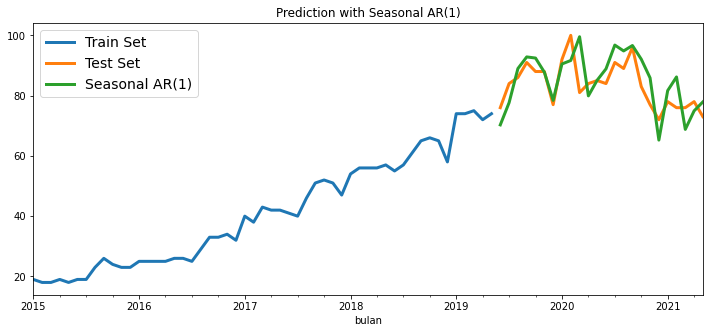

In [42]:
#plot prediction
plt.figure(figsize=(12,5))
ds_train.plot(label="Train Set", linewidth=3)
ds_test.plot(label="Test Set", linewidth=3)
model_forecast['Seasonal AR(1)'].plot(linewidth=3)
plt.title('Prediction with Seasonal AR(1)')
plt.legend(prop={'size': 14})

### More Analysis: Decomposition

To better understand a time series dataset, usually we can think time series to have 3 different components:
1) Trend: The linear increasing or decreasing behavior of the series over time.  
2) Seasonality: The repeating patterns or cycles of behavior over time.  
3) Random: The variability in the observations that cannot be explained by the model.  

There is two types of decomposition models. We usually use additive model when the volatility is constant on increasing value and multiplicative model when the volatility is increasing on increasing value.:  
Additive:  
y = Trend + Seasonality + Random  
Multiplicative:  
y = Trend * Seasonal * Random

Article: [Additive & Multiplicative](https://online.stat.psu.edu/stat510/lesson/5/5.1)

Now, I'm going to extract these components into it's own series.

Text(0.5, 1.0, 'data_science original')

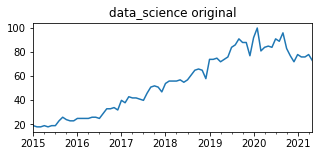

In [43]:
data_science.plot(figsize=(5,2))
plt.xlabel("")
plt.title("data_science original")

#### Extract Trend

Text(0.5, 1.0, 'data_science trend')

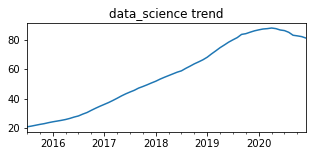

In [44]:
#Extract trend with 12 period moving average
trend = data_science.rolling(12,center=True).mean().dropna()
trend.plot(figsize=(5,2))
plt.xlabel("")
plt.title('data_science trend')

#### Extract Seasonality

There is two method of extracting seasonality. On which method we should use depend on the type of our model (additive or multiplicative). In our case, the dataset has multiplicative properties.  
Formula:  
- Additive: series - trend
- Multiplicative: series $\div$ trend

Text(0.5, 0, '')

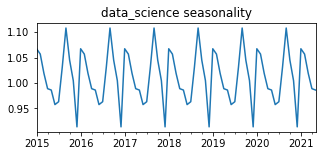

In [45]:
#de-trend the original series
detrend = data_science[trend.index] / trend

#average the seasonality then repeat to the length of the original series
seasonality = detrend.groupby(detrend.index.month).mean()
period = len(data_science.index)
seasonality = pd.Series(np.tile(seasonality,int(np.ceil(period/12))))[:period]
seasonality.index = data_science.index
seasonality.plot(figsize=(5,2))
plt.title('data_science seasonality')
plt.xlabel("")

#### Remaining Random Noise

Formula:  
Random = Series $\div$ (Trend . Seasonal)

Text(0.5, 0, '')

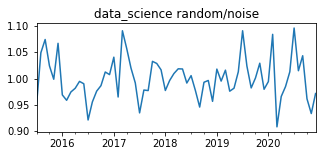

In [46]:
random = (data_science / (trend * seasonality)).dropna()
random.plot(figsize=(5,2))
plt.title('data_science random/noise')
plt.xlabel("")

#### Decompose with Statsmodel

Using statsmodel is an easier method to decompose a time series. But, It's nice to try to do it manually first to know how decomposition works.

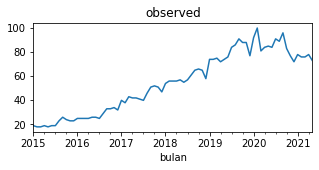

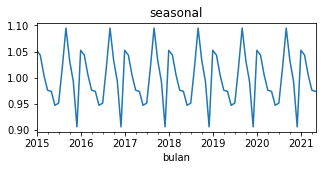

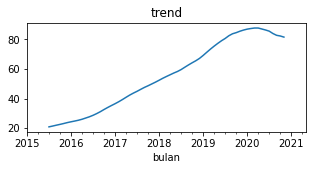

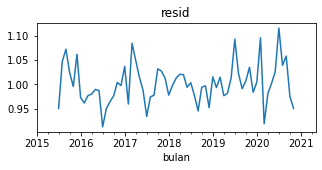

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(5,2))
seasonal_decompose(data_science,model='multiplicative').observed.plot()
plt.title('observed')
plt.figure(figsize=(5,2))
seasonal_decompose(data_science,model='multiplicative').seasonal.plot()
plt.title('seasonal')
plt.figure(figsize=(5,2))
seasonal_decompose(data_science,model='multiplicative').trend.plot()
plt.title('trend')
plt.figure(figsize=(5,2))
seasonal_decompose(data_science,model='multiplicative').resid.plot()
plt.title('resid')
plt.show()

From this trend and seasonal decomposition we could get some insight. Here is some insight I found:
- September and early months of the year is where popularity is higher. June and December are at it's lowest.
- Since 2015 "data science" search popularity steadily increasing and peaked in 2020 and start decending since then. The world crises in 2020 maybe played some role on it's descend.